In [15]:
#라이브러리
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

In [16]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_fix_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,"1,099.70",6764.11,0.87,NaN,90.95,0.47,"3,133.73"
1758,2021.02.18,"1,107.70",6652.76,0.87,NaN,90.59,0.49,"3,086.66"
1759,2021.02.19,"1,105.70",6712.32,0.86,NaN,90.36,0.51,"3,107.62"
1760,2021.02.22,"1,107.10",6635.92,0.86,NaN,90.01,0.50,"3,079.75"
1761,2021.02.23,"1,106.50",6607.24,0.86,NaN,90.17,0.49,"3,070.09"


In [17]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","KRX100", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))


In [18]:
#천단위 쉼표 제거
df1['ExchangeRate'] = df1['ExchangeRate'].str.replace(',','')
df1['KOSPI'] = df1['KOSPI'].str.replace(',','')
df1.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.70,6764.11,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.70,6652.76,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.70,6712.32,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.10,6635.92,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.50,6607.24,0.86,NaN,90.17,0.49,3070.09


In [19]:
#오브젝트형 데이터 실수로 형변환
df1["KOSPI"] = pd.to_numeric(df1.KOSPI, errors='coerce')
df1["ExchangeRate"] = pd.to_numeric(df1.ExchangeRate, errors='coerce')

In [22]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     1
KRX100           6
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [23]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,6764.11,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,6652.76,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,6712.32,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,6635.92,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,6607.24,0.86,0.0815,90.17,0.49,3070.09


In [24]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [25]:
df_intp.tail() #기초 완성!

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021-02-17,1099.7,6764.11,0.87,0.0815,90.95,0.47,3133.73
1758,2021-02-18,1107.7,6652.76,0.87,0.0815,90.59,0.49,3086.66
1759,2021-02-19,1105.7,6712.32,0.86,0.0815,90.36,0.51,3107.62
1760,2021-02-22,1107.1,6635.92,0.86,0.0815,90.01,0.50,3079.75
1761,2021-02-23,1106.5,6607.24,0.86,0.0815,90.17,0.49,3070.09


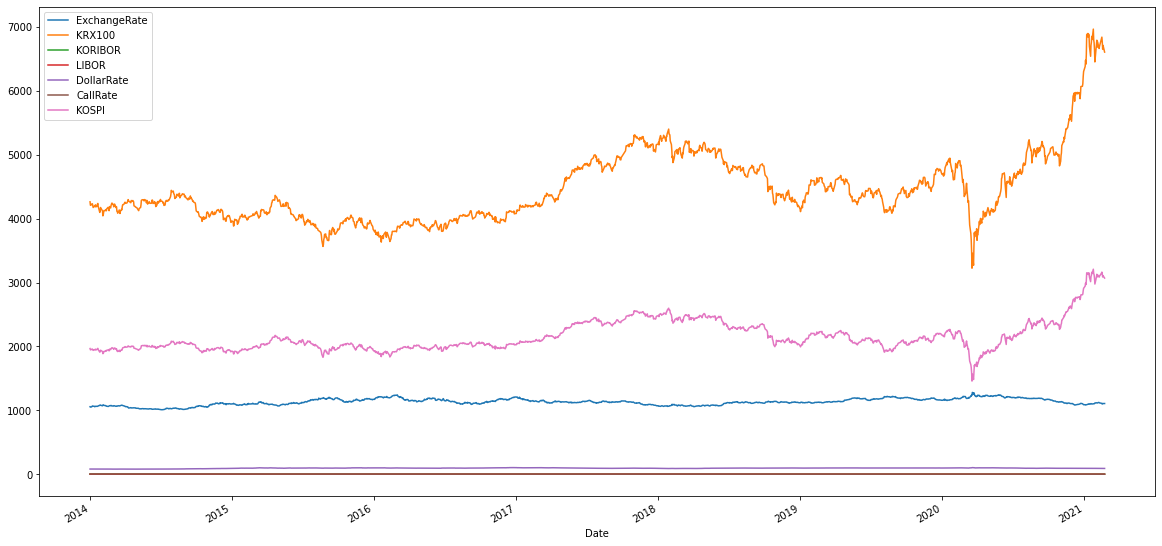

In [26]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))
#표준화 필수의 느낌이 난다..

In [27]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS =3
X = df_intp.index
y = df_intp['ExchangeRate']

folds = TimeSeriesSplit(n_splits = N_SPLITS)

In [77]:
feature_columns = [
    'KRX100',
    'KORIBOR',
    'LIBOR',
    'DollarRate',
    'CallRate',
    'KOSPI'
]

target_column = ['ExchangeRate']

train_size = int(0.8* len(df_intp))

multivariate_df = df_intp[['Date']+target_column +feature_columns].copy()
multivariate_df.columns = ['ds', 'y']+ feature_columns
multivariate_df.head()
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6,7]]),pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6,7]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [86]:
from fbprophet import Prophet
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train the model
model = Prophet()
model.add_regressor('KRX100')
model.add_regressor('KORIBOR')
# model.add_regressor('LIBOR')
# model.add_regressor('DollarRate')
# model.add_regressor('CallRate')
model.add_regressor('KOSPI')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 22.261706870426792


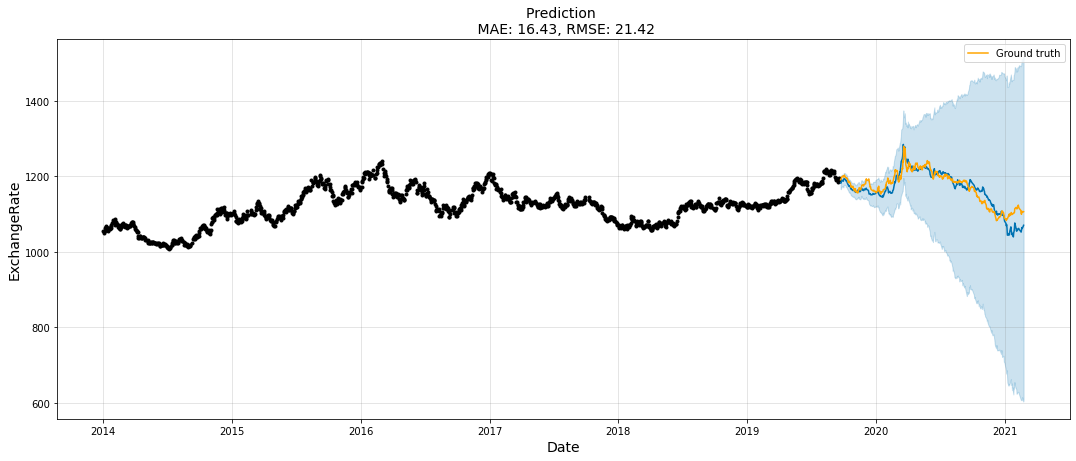

In [82]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='ExchangeRate', fontsize=14)

plt.show()

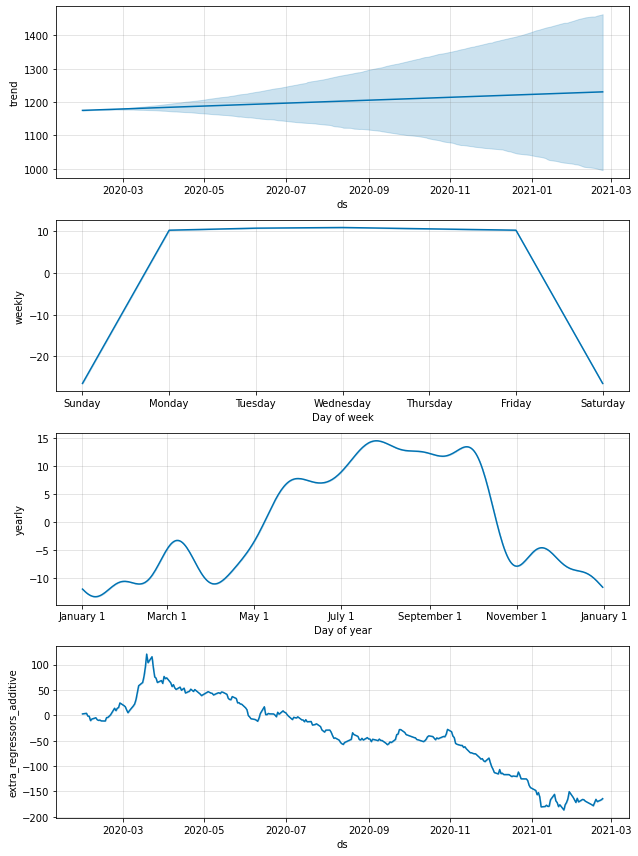

In [63]:
fig2 = model.plot_components(y_pred)

In [34]:
y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,DollarRate,DollarRate_lower,DollarRate_upper,KOSPI,KOSPI_lower,KOSPI_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-31,1166.593361,1163.894627,1194.719228,1166.593361,1166.593361,12.961561,12.961561,12.961561,0.273919,0.273919,0.273919,11.907008,11.907008,11.907008,13.235480,13.235480,13.235480,9.633444,9.633444,9.633444,-10.961917,-10.961917,-10.961917,0.0,0.0,0.0,1178.500369
1,2020-02-03,1166.964095,1164.324049,1195.992436,1166.964095,1166.964095,14.514171,14.514171,14.514171,0.293056,0.293056,0.293056,13.515733,13.515733,13.515733,14.807227,14.807227,14.807227,9.581419,9.581419,9.581419,-10.872913,-10.872913,-10.872913,0.0,0.0,0.0,1180.479827
2,2020-02-04,1167.087673,1159.326502,1190.137881,1167.087673,1167.087673,15.120067,15.120067,15.120067,-5.450926,-5.450926,-5.450926,8.856708,8.856708,8.856708,9.669141,9.669141,9.669141,10.066913,10.066913,10.066913,-10.879346,-10.879346,-10.879346,0.0,0.0,0.0,1175.944380
3,2020-02-05,1167.211250,1161.469509,1192.471468,1167.211250,1167.211250,16.407597,16.407597,16.407597,-6.588829,-6.588829,-6.588829,9.151478,9.151478,9.151478,9.818768,9.818768,9.818768,10.229641,10.229641,10.229641,-10.896931,-10.896931,-10.896931,0.0,0.0,0.0,1176.362728
4,2020-02-06,1167.334828,1152.959098,1183.086196,1167.334828,1167.334828,17.164968,17.164968,17.164968,-15.761242,-15.761242,-15.761242,0.419441,0.419441,0.419441,1.403726,1.403726,1.403726,9.936333,9.936333,9.936333,-10.920618,-10.920618,-10.920618,0.0,0.0,0.0,1167.754269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2021-02-17,1213.923662,814.924173,1288.886847,982.302787,1448.902568,-11.425773,-11.425773,-11.425773,-149.099064,-149.099064,-149.099064,-160.135584,-160.135584,-160.135584,-160.524837,-160.524837,-160.524837,10.229641,10.229641,10.229641,-9.840388,-9.840388,-9.840388,0.0,0.0,0.0,1053.788077
261,2021-02-18,1214.047239,817.435669,1298.078459,981.166390,1449.755603,-12.789040,-12.789040,-12.789040,-142.170073,-142.170073,-142.170073,-154.547021,-154.547021,-154.547021,-154.959113,-154.959113,-154.959113,9.936333,9.936333,9.936333,-9.524241,-9.524241,-9.524241,0.0,0.0,0.0,1059.500218
262,2021-02-19,1214.170817,819.852850,1290.926477,980.029993,1450.608637,-13.660016,-13.660016,-13.660016,-145.255513,-145.255513,-145.255513,-158.451847,-158.451847,-158.451847,-158.915529,-158.915529,-158.915529,9.633444,9.633444,9.633444,-9.169761,-9.169761,-9.169761,0.0,0.0,0.0,1055.718971
263,2021-02-22,1214.541551,821.946179,1299.285947,975.927324,1453.561723,-14.985415,-14.985415,-14.985415,-141.152878,-141.152878,-141.152878,-154.469700,-154.469700,-154.469700,-156.138294,-156.138294,-156.138294,9.581419,9.581419,9.581419,-7.912825,-7.912825,-7.912825,0.0,0.0,0.0,1060.071850
